# Netoyage des données

## Les  imports

In [1]:
# !pip install fastparquet

In [ ]:
## Modifier le WorkDirectory
wdir = '/tmp/gas'
os.chdir(wdir)

In [2]:
#!pip install geopy

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('fr')

In [2]:
print('current work dir is:', os.getcwd())

current work dir is: /home/houcine/workspace/school-eda-serviceStations


In [77]:
# limiter le nombre de lignes à afficher à 4
# au lieu de faire un head() + un tail() il suffira d'afficher la DataFrame
pd.options.display.max_rows = 4

## Typage des DataFrames

### chargement de **pdv**

In [172]:
pdv = pd.read_csv('pdv.csv', dtype={"annee":str,"cp":str})

### cleaning ***longitude*** and ***latitude***

In metropolitan France :
<br>
the **latitude**  is between 42 and 51
<br>
and **longitude** is between -5 and 10

#### First we need to scale **longitude** and **latitude** correctly

The vaste majority should be scaled by 100,000. but there are some values that are already scaled properly.
So, we will only scale values that aren't in the right range.

Due to possible swaping between longitude and latitude we should take into account the global minimum range and global maximum range in order to scale correctly.
This means that values of longitude and latitude should be between -5 and 51.

In [173]:
# scale by 100,000 if longi or lati aren't in correct range
pdv.latitude.loc[~(-5 < pdv.latitude) &  (pdv.latitude < 51)]    /= 100000
pdv.longitude.loc[~(-5 < pdv.longitude) &  (pdv.longitude < 51)] /= 100000

We would like to drop incorrect longitude and latitude but first we can correct the ones that were inversed

In [174]:
# handling inversed values
sub_pdv = pdv.loc[
            (42 <= pdv.longitude)&\
            (pdv.longitude <= 51)&\
            (-5 <= pdv.latitude)&\
            (pdv.latitude <= 10)]

the idea behind this step is this :
<br>
we compare longitude and latitude of the postal code with longitude and latitude of the **pdv** file

In [179]:
# loop over all sub_pdv values by using their original index (the one in pdv dataframe)
for index in sub_pdv.index:
    cp        = sub_pdv.loc[index,["cp"]][0]
    latitude  = sub_pdv.loc[index,["latitude"]][0]
    longitude = sub_pdv.loc[index,["longitude"]][0]
    
    # geographical informations associated to this postal code (note that we are only using France postal codes)
    geo_info = nomi.query_postal_code(cp)
    
    # calculating the squared difference between the postal code longitude
    # and latitude and we will compare them the to longitude and latitude of the station
    lati_diff_squared = (latitude - geo_info.longitude)**2
    long_diff_squared = (longitude - geo_info.latitude)**2
    
    is_it_near = lati_diff_squared < 2 and\
                     long_diff_squared < 2
    
    if not is_it_near:
        print("index :",i)
        print("/t cp",cp, ":",longitude, latitude)
        
    # print(res['country code'], res.postal_code)

index : 140673
/t cp 13546 : 43.506 5.399
index : 140673
/t cp 14700 : 46.165 0.204
index : 140673
/t cp 20148 : 43.72 7.292000000000001
index : 140673
/t cp 31076 : 43.608999999999995 1.3969999999999998
index : 140673
/t cp 53102 : 48.302 -0.622
index : 140673
/t cp 59156 : 48.858999999999995 2.347
index : 140673
/t cp 61790 : 48.787 1.666
index : 140673
/t cp 68124 : 48.086000000000006 7.314
index : 140673
/t cp 70004 : 47.635 6.157
index : 140673
/t cp 78205 : 48.981 1.689
index : 140673
/t cp 85804 : 46.696000000000005 -1.9280000000000002
index : 140673
/t cp 86102 : 46.792 0.526
index : 140673
/t cp 56890 : 47.6831 -5.0996110000000005e-05


after manually verifying the **latitude** and **longitude** that we couldn't find with *"pgeocode"* library 
<br>
we conclude that all **longitudes** and **latitudes** that were in the correct range were swaped

### swap values

In [111]:
lat = sub_pdv.latitude.copy()
sub_pdv.loc[:,"latitude"] = sub_pdv.longitude
sub_pdv.loc[:,"longitude"] = lat
sub_pdv

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville
506,2019,6190006,43.763940,7.480690,06190,R,NaN,NaN,NaN,175 Avenue Louis Pasteur,ROQUEBRUNE-CAP-MARTIN
538,2019,6220004,43.579880,7.062040,06220,R,NaN,NaN,NaN,D6007,Vallauris
...,...,...,...,...,...,...,...,...,...,...,...
140483,2016,94500001,48.823150,2.494980,94500,R,06:00:00,21:00:00,NaN,114 Avenue du Général de Gaulle,CHAMPIGNY-SUR-MARNE
140673,2016,95500002,48.967186,2.464734,95500,R,05:30:00,20:30:00,NaN,RN 370,GONESSE


In [112]:
pdv.update(sub_pdv)
pdv.loc[sub_pdv.index]

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville
506,2019.0,6190006.0,43.763940,7.480690,06190,R,NaN,NaN,NaN,175 Avenue Louis Pasteur,ROQUEBRUNE-CAP-MARTIN
538,2019.0,6220004.0,43.579880,7.062040,06220,R,NaN,NaN,NaN,D6007,Vallauris
...,...,...,...,...,...,...,...,...,...,...,...
140483,2016.0,94500001.0,48.823150,2.494980,94500,R,06:00:00,21:00:00,NaN,114 Avenue du Général de Gaulle,CHAMPIGNY-SUR-MARNE
140673,2016.0,95500002.0,48.967186,2.464734,95500,R,05:30:00,20:30:00,NaN,RN 370,GONESSE


Now, latitudes and longitudes that remain outside of the correcte range will be converted to **Nan**

In [118]:
d = pdv.loc[(42 > pdv.latitude)|\
        (pdv.latitude > 51)|\
        (-5 > pdv.longitude)|\
        (pdv.longitude > 10)]

In [132]:
mask = d.longitude * 100000 < 100

In [134]:
pdv.loc[d.index[mask],:]

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville
1181,2019,13010007,5.421000,43.27000,13010,R,NaN,NaN,NaN,260 Boulevard Paul Claudel,MARSEILLE
1231,2019,13015012,0.000000,0.00000,13015,R,NaN,NaN,NaN,"20-22, RN DE ST ANTOINE",MARSEILLE
...,...,...,...,...,...,...,...,...,...,...,...
136847,2016,68520009,47.715912,7.13773,68520,A,00:00:06,23:59:06,NaN,Aire de Porte d' Alsace - A36,BURNHAUPT LE BAS
138087,2016,76700005,49.503000,0.23300,76700,R,01:00:00,01:00:00,NaN,parc de l'estuaire,GONFREVILLE-L'ORCHER


/home/houcine/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


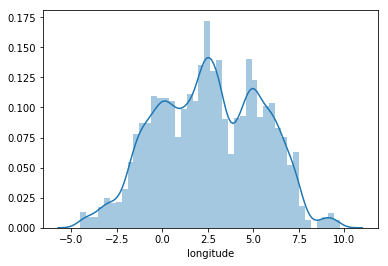

In [113]:
sns.distplot(pdv.dropna().longitude)

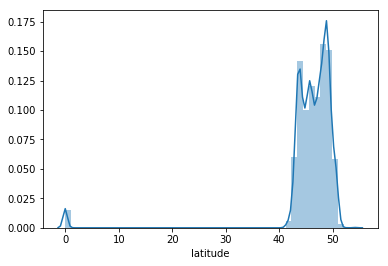

In [114]:
sns.distplot(pdv.dropna().latitude)

In [13]:
pdv.latitude.describe()

count    1.396480e+05
mean     4.608540e+06
std      6.176435e+05
min     -2.433288e+06
25%      4.476511e+06
50%      4.715301e+06
75%      4.876788e+06
max      6.260656e+06
Name: latitude, dtype: float64

In [7]:
pdv.loc[pdv.cp=="35***","cp"] = 35000

In [28]:
!pip install pgeocode

postal_code                 75013
country code                   FR
place_name        Paris 13, Paris
state_name          Île-de-France
state_code                     11
                       ...       
community_name              Paris
community_code                751
latitude                  48.8322
longitude                 2.35245
accuracy                        5
Name: 0, Length: 12, dtype: object

In [30]:
pdv.loc[(pdv.adresse == ad) & (pdv.ville.isna())]

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville


In [31]:
pdv.isna().sum()

annee                      0
id                         0
latitude                1076
longitude               1053
cp                         0
                       ...  
ouverture_debut        25498
ouverture_fin          25498
ouverture_saufjour    119101
adresse                    0
ville                      0
Length: 11, dtype: int64

In [32]:
# normalisation des longitudes et latitude 
pdv.loc[:,'latitude']   = pdv.latitude/100000
pdv.loc[:, 'longitude'] = pdv.longitude/100000

In [33]:
pdv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140724 entries, 0 to 140723
Data columns (total 11 columns):
annee                 140724 non-null int64
id                    140724 non-null int64
latitude              139648 non-null float64
longitude             139671 non-null float64
cp                    140724 non-null object
pop                   140724 non-null object
ouverture_debut       115226 non-null object
ouverture_fin         115226 non-null object
ouverture_saufjour    21623 non-null object
adresse               140724 non-null object
ville                 140724 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 11.8+ MB


- **convertion des categories**

In [34]:
findLargeCols(pdv)

col_name                            n               n_distinct     ratio
annee                              140724                   13    10825%
id                                 140724                16826        8%
latitude                           140724                19737        7%
longitude                          140724                20006        7%
cp                                 140724                 8770       16%
pop                                140724                    4    35181%
ouverture_debut                    140724                  766      184%
ouverture_fin                      140724                  880      160%
ouverture_saufjour                 140724                   32     4398%
adresse                            140724                15393        9%
ville                              140724                 9174       15%


les columns **'annee','pop','ouverture_saufjour','rupture_id','rupture_nom','fermeture_type'** mieux vaut les considérer des categories

In [35]:
pdv['annee']              = pdv['annee'].astype('category')
pdv['pop']                = pdv['pop'].astype('category')
pdv['ouverture_saufjour'] = pdv['ouverture_saufjour'].astype('category')
pdv['rupture_id']         = pdv['rupture_id'].astype('category')
pdv['rupture_nom']        = pdv['rupture_nom'].astype('category')
pdv['fermeture_type']     = pdv['fermeture_type'].astype('category')


KeyError: 'rupture_id'

- **convertion des dates et temps**

In [11]:
mask = pdv['ouverture_debut'].str.len() == 5
pdv.loc[mask,'ouverture_debut'] = pdv.loc[mask,'ouverture_debut'] + ":00"

In [12]:
mask = pdv['ouverture_fin'].str.len() == 5
pdv.loc[mask,'ouverture_fin'] = pdv.loc[mask,'ouverture_fin'] + ":00"

In [13]:
mask = pdv['rupture_debut'].str[:4] == "0216"
pdv.loc[mask,'rupture_debut'] = "2016" + pdv[mask]['rupture_debut'].str[4:]

KeyError: 'rupture_debut'

In [77]:
mask = pdv['rupture_debut'].str[:4] == "0216"
pdv[mask]['rupture_debut']

Series([], Name: rupture_debut, dtype: object)

In [14]:
pdv['ouverture_debut'] = pd.to_timedelta((pdv['ouverture_debut']))
pdv['ouverture_fin']   = pd.to_timedelta((pdv['ouverture_fin']))

In [15]:
pdv['ouverture_debut'][136707] , pdv['ouverture_fin'][136707]

(Timedelta('0 days 01:00:00'), Timedelta('0 days 01:00:00'))

In [16]:
pdv['ouverture_fin'][136707] - pdv['ouverture_debut'][136707]

Timedelta('0 days 00:00:00')

In [17]:
pdv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140724 entries, 0 to 140723
Data columns (total 11 columns):
annee                 140724 non-null int64
id                    140724 non-null int64
latitude              139648 non-null float64
longitude             139671 non-null float64
cp                    140724 non-null object
pop                   140724 non-null object
ouverture_debut       128011 non-null timedelta64[ns]
ouverture_fin         128011 non-null timedelta64[ns]
ouverture_saufjour    21623 non-null object
adresse               140724 non-null object
ville                 140724 non-null object
dtypes: float64(2), int64(2), object(5), timedelta64[ns](2)
memory usage: 11.8+ MB


In [18]:
pdv['rupture_debut']   = pd.to_datetime(pdv['rupture_debut'])
pdv['rupture_fin']     = pd.to_datetime(pdv['rupture_fin'])
pdv['fermeture_debut'] = pd.to_datetime(pdv['fermeture_debut'])
pdv['fermeture_fin']   = pd.to_datetime(pdv['fermeture_fin'])

KeyError: 'rupture_debut'

In [23]:
pdv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136712 entries, 0 to 136711
Data columns (total 18 columns):
annee                 136712 non-null category
id                    136712 non-null int64
latitude              135706 non-null float64
longitude             135728 non-null float64
cp                    136712 non-null object
pop                   136712 non-null category
ouverture_debut       124114 non-null timedelta64[ns]
ouverture_fin         124114 non-null timedelta64[ns]
ouverture_saufjour    136712 non-null category
adresse               136712 non-null object
ville                 136709 non-null object
rupture_id            136712 non-null category
rupture_nom           136712 non-null category
rupture_debut         136712 non-null datetime64[ns]
rupture_fin           44013 non-null datetime64[ns]
fermeture_type        136669 non-null category
fermeture_debut       136669 non-null datetime64[ns]
fermeture_fin         39851 non-null datetime64[ns]
dtypes: category(6

In [98]:
pdv

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville,rupture_id,rupture_nom,rupture_debut,rupture_fin,fermeture_type,fermeture_debut,fermeture_fin
0,2007,1000001,4.620114e+06,519791.000000,01000,R,01:00:00,01:00:00,NaN,ROUTE NATIONALE,S-BOURG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007,1000002,4.621842e+06,522767.000000,01000,R,08:45:00,19:30:00,Dimanche,16 Avenue de Marboz,BOURG-EN-BRESSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,1000003,4.619965e+06,524047.000000,01000,R,16:00:00,20:00:00,Samedi;Dimanche,Bld Charles De Gaulle,Bourg-en-Bresse,NaN,NaN,NaN,NaN,D,2007-10-30 09:47:04.590533,NaN
3,2007,1000004,4.618836e+06,524447.000000,01000,R,01:00:00,01:00:00,NaN,chal Juin,Bourg-en-Bresse,NaN,NaN,NaN,NaN,D,2007-10-30 09:47:04.590533,NaN
4,2007,1000006,4.620754e+06,523758.000000,01000,R,01:00:00,01:00:00,Dimanche,1 Boulevard John Kennedy,BOURG-EN-BRESSE,NaN,NaN,NaN,NaN,D,2007-10-30 09:47:04.590533,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140719,2017,95870005,4.893676e+06,220715.000000,95870,R,06:00:43,21:00:43,NaN,ri,BEZONS,2.0,SP95,2013-03-20T16:58:00,NaN,D,2017-12-19T00:00:00,NaN
140720,2017,95870007,4.892824e+06,221140.000000,95870,R,06:00:01,21:00:01,NaN,ri,BEZONS,2.0,SP95,2011-08-31T22:43:00,NaN,D,2017-12-19T00:00:00,NaN
140721,2017,95870009,4.892770e+06,221346.318047,95870,R,06:00:00,21:30:00,NaN,151 AV GABRIEL PERI,BEZONS,2.0,SP95,2011-08-31T22:43:00,NaN,D,2017-12-19T00:00:00,NaN
140722,2017,96600001,4.875637e+06,241048.000000,94600,R,07:30:27,20:30:27,Dimanche,16 Avenue de Newburn,Choisy-le-Roi,5.0,E10,2009-12-11T21:53:00,NaN,D,2017-12-19T00:00:00,NaN


- **enregistrer la df compréssée**

In [36]:
pdv.to_parquet('pdv.gzip', 
               compression='gzip')

- **liberer la mémoire**

In [37]:
del pdv

### netoyage de **prix**

In [38]:
prix = pd.read_csv('prix.csv')

In [39]:
prix

,annee,id_pdv,nom,id,maj,valeur
0,2019,1000001,Gazole,1.0,2019-01-04T10:53:48,1328.0
1,2019,1000001,Gazole,1.0,2019-01-07T10:25:25,1348.0
2,2019,1000001,Gazole,1.0,2019-01-10T08:54:28,1374.0
3,2019,1000001,Gazole,1.0,2019-01-11T10:01:54,1387.0
4,2019,1000001,Gazole,1.0,2019-01-14T11:04:53,1394.0
...,...,...,...,...,...,...
28552949,2016,95870009,SP98,6.0,2016-12-28T00:12:00,1427.0
28552950,2016,95870009,SP98,6.0,2016-12-29T00:12:00,1427.0
28552951,2016,95870009,SP98,6.0,2016-12-30T00:12:00,1432.0
28552952,2016,95870009,SP98,6.0,2016-12-31T00:12:00,1439.0


In [40]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28552954 entries, 0 to 28552953
Data columns (total 6 columns):
annee     int64
id_pdv    int64
nom       object
id        float64
maj       object
valeur    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.3+ GB


**la DataFrame prix est trés grande (1,3 GB).On peut diminuer sa taille en convertant des variables en Category.**

- **convertion des categories**

In [41]:
findLargeCols(prix)

col_name                            n               n_distinct     ratio
annee                            28552954                   13  2196381%
id_pdv                           28552954                16826     1697%
nom                              28552954                    7  4078993%
id                               28552954                    7  4078993%
maj                              28552954             11299903        3%
valeur                           28552954                 1944    14688%


les columns **'id_pdv','annee','nom','id'** mieux vaut les considérer des categories. on laisse **'valeur'** en **int**

In [42]:
prix["id_pdv"] = prix["id_pdv"].astype('category')
prix["annee"]  = prix["annee"].astype('category')
prix["nom"]    = prix["nom"].astype('category')
prix["id"]     = prix["id"].astype('category')

In [43]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28552954 entries, 0 to 28552953
Data columns (total 6 columns):
annee     category
id_pdv    category
nom       category
id        category
maj       object
valeur    float64
dtypes: category(4), float64(1), object(1)
memory usage: 572.6+ MB


**la taille de la df diminue de 1.3GB à 0.57GB**

- **convertion des dates et temps**

In [44]:
prix['maj'] = pd.to_datetime(prix['maj'])

In [45]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28552954 entries, 0 to 28552953
Data columns (total 6 columns):
annee     category
id_pdv    category
nom       category
id        category
maj       datetime64[ns]
valeur    float64
dtypes: category(4), datetime64[ns](1), float64(1)
memory usage: 572.6 MB


In [46]:
prix

,annee,id_pdv,nom,id,maj,valeur
0,2019,1000001,Gazole,1.0,2019-01-04 10:53:48,1328.0
1,2019,1000001,Gazole,1.0,2019-01-07 10:25:25,1348.0
2,2019,1000001,Gazole,1.0,2019-01-10 08:54:28,1374.0
3,2019,1000001,Gazole,1.0,2019-01-11 10:01:54,1387.0
4,2019,1000001,Gazole,1.0,2019-01-14 11:04:53,1394.0
...,...,...,...,...,...,...
28552949,2016,95870009,SP98,6.0,2016-12-28 00:12:00,1427.0
28552950,2016,95870009,SP98,6.0,2016-12-29 00:12:00,1427.0
28552951,2016,95870009,SP98,6.0,2016-12-30 00:12:00,1432.0
28552952,2016,95870009,SP98,6.0,2016-12-31 00:12:00,1439.0


- **enregistrer la df compréssée**

In [47]:
prix.to_parquet('prix.gzip',
               compression='gzip')

- **liberer la mémoire**

In [48]:
del prix

### netoyage de **services**

In [49]:
services = pd.read_csv('services.csv')

In [50]:
services

,annee,id_pdv,service
0,2019,1000001,Station de gonflage
1,2019,1000001,"Vente de gaz domestique (Butane, Propane)"
2,2019,1000001,DAB (Distributeur automatique de billets)
3,2019,1000002,"Vente de gaz domestique (Butane, Propane)"
4,2019,1000002,DAB (Distributeur automatique de billets)
...,...,...,...
837086,2016,95870009,Lavage multi-programmes
837087,2016,96600001,Carburant qualité supérieure
837088,2016,96600001,Boutique non alimentaire
837089,2016,96600001,Baie de service auto


In [51]:
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837091 entries, 0 to 837090
Data columns (total 3 columns):
annee      837091 non-null int64
id_pdv     837091 non-null int64
service    837091 non-null object
dtypes: int64(2), object(1)
memory usage: 19.2+ MB


- **convertion des categories**

In [52]:
findLargeCols(services)

col_name                            n               n_distinct     ratio
annee                              837091                   13    64392%
id_pdv                             837091                15179       55%
service                            837091                   36    23253%


les columns **'annee','id_pdv','service'** mieux vaut les considérer des categories.

In [53]:
services["annee"]   = services["annee"].astype('category')
services["id_pdv"]  = services["id_pdv"].astype('category')
services["service"] = services["service"].astype('category')

In [54]:
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837091 entries, 0 to 837090
Data columns (total 3 columns):
annee      837091 non-null category
id_pdv     837091 non-null category
service    837091 non-null category
dtypes: category(3)
memory usage: 3.9 MB


In [56]:
services

,annee,id_pdv,service
0,2019,1000001,Station de gonflage
1,2019,1000001,"Vente de gaz domestique (Butane, Propane)"
2,2019,1000001,DAB (Distributeur automatique de billets)
3,2019,1000002,"Vente de gaz domestique (Butane, Propane)"
4,2019,1000002,DAB (Distributeur automatique de billets)
...,...,...,...
837086,2016,95870009,Lavage multi-programmes
837087,2016,96600001,Carburant qualité supérieure
837088,2016,96600001,Boutique non alimentaire
837089,2016,96600001,Baie de service auto


- **enregistrer la df compréssée**

In [57]:
services.to_parquet('services.gzip',
               compression='gzip')

- **liberer la mémoire**

In [58]:
del services